<a href="https://colab.research.google.com/github/dgsmith1988/ECSE-552-Final-Project/blob/rubert/execution_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overall Script Description
Run through each of the different cells to get things working. What should happen is that you connect to Google Drive, some data is transferred and then unzipped and then the model is trained on it and outputs data indicating correct operation. On the Google Drive there should also be files added under "Measurements" which have a date and time-stamp corresponding to the output of training process. The time stamps are generated by the Google Colab instance so they won't match exactly with your local time depending on where the instance they supplied us is located.

The cells are broken up based on functionality to make it easier to debug/profile/troubleshoot any issues which might come up.

# Configure Directories/Paths/Languages
The following cell is where you configure which languages you want to work with (from the three which are available on Google Drive at the moment). It is also where you set the paths to where the Google Drive will be mounted and where the data is extracted to.


In [1]:
import os
languages = ["EN", "DE", "ES"]
mount_point = '/content/drive'
load_path = os.path.join(mount_point, 'MyDrive/ECSE-552-FP/Data/')
unzip_path = '/content/speech_data'
save_path = '/MyDrive/ECSE-552-FP/Measurements'

from google.colab import drive
drive.mount(mount_point)

Mounted at /content/drive


# Download and extract the dataset zip files
The following downloads and extracts the language zip files from Google Drive. It is done separately in it's own cell to make it easier to profile/debug things if there are issues in the network connection between Google Drive and Google Colab. 

This is separate from dataset creation for two reasons. The first is that if the network accesses are obscured by accessing the data via the network drive, it is much harder to debug bottlenecks in creating the dataset. The second is that all of the data must be transferred once at somepoint during one epoch, so it's easier to do it all up front and make sure the data is on the Colab instance before training. Localizing as much as possible to the Colab instance during training makes things easier to debug as well as more efficient.

There is a commented out code which allows you to select between the "debug" dataset and the "full" dataset for the languages. The "debug" set consists of a smaller subset (20 samples for each language) to aid in debugging the dataflow in models. It alleviates the need to run through the entire dataset and helps ensure all the pipes are connected correctly.

In [2]:
for language in languages:
    language_dir_path = os.path.join(unzip_path, language)
    os.makedirs(language_dir_path, exist_ok=True)
    archive = language + "_debug_set" + ".zip"
    #archive = language + ".zip"
    !unzip {os.path.join(load_path, archive)} -d {language_dir_path}

Archive:  /content/drive/MyDrive/ECSE-552-FP/Data/EN_debug_set.zip
   creating: /content/speech_data/EN/1snoke-20120412-hge/
  inflating: /content/speech_data/EN/1snoke-20120412-hge/a0405.wav  
  inflating: /content/speech_data/EN/1snoke-20120412-hge/a0406.wav  
  inflating: /content/speech_data/EN/1snoke-20120412-hge/a0407.wav  
  inflating: /content/speech_data/EN/1snoke-20120412-hge/a0408.wav  
  inflating: /content/speech_data/EN/1snoke-20120412-hge/a0409.wav  
  inflating: /content/speech_data/EN/1snoke-20120412-hge/a0410.wav  
  inflating: /content/speech_data/EN/1snoke-20120412-hge/a0411.wav  
  inflating: /content/speech_data/EN/1snoke-20120412-hge/a0412.wav  
  inflating: /content/speech_data/EN/1snoke-20120412-hge/a0413.wav  
  inflating: /content/speech_data/EN/1snoke-20120412-hge/a0414.wav  
   creating: /content/speech_data/EN/Bahoke-20130721-uop/
  inflating: /content/speech_data/EN/Bahoke-20130721-uop/b0520.wav  
  inflating: /content/speech_data/EN/Bahoke-20130721-uop/b

# Download the source code from GitHub

In [10]:
user = "dgsmith1988"
repo = "ECSE-552-Final-Project"
src_dir = "Code"
pyfiles = ["models.py", "train.py", "dict_logger.py", "feature_extraction.py"]

for pyfile in pyfiles:
    !rm {pyfile}
    url = f"https://raw.githubusercontent.com/{user}/{repo}/rubert/{src_dir}/{pyfile}"
    !wget {url}


--2022-03-18 13:01:17--  https://raw.githubusercontent.com/dgsmith1988/ECSE-552-Final-Project/rubert/Code/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5628 (5.5K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]   5.50K  --.-KB/s    in 0s      

2022-03-18 13:01:17 (64.6 MB/s) - ‘models.py’ saved [5628/5628]

--2022-03-18 13:01:17--  https://raw.githubusercontent.com/dgsmith1988/ECSE-552-Final-Project/rubert/Code/train.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7679 (7.5K) [t

# Install the supporting/required libraries



In [4]:
!pip install torchmetrics
!pip install pytorch-lightning
!pip install librosa

     |████████████████████████████████| 397 kB 5.3 MB/s 
     |████████████████████████████████| 527 kB 5.1 MB/s 
     |████████████████████████████████| 134 kB 47.5 MB/s 
     |████████████████████████████████| 952 kB 41.8 MB/s 
     |████████████████████████████████| 596 kB 45.9 MB/s 
     |████████████████████████████████| 829 kB 40.7 MB/s 
     |████████████████████████████████| 1.1 MB 41.7 MB/s 
     |████████████████████████████████| 271 kB 52.2 MB/s 
     |████████████████████████████████| 144 kB 51.1 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=3593fad001391b83dade04d520065dd8cff4bf6d83c2b78e4ed7aed74fa5223c
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfull

# Run/Train the Model

Preparing and splitting dataset...


3it [00:00,  8.28it/s]
3it [00:00,  7.64it/s]
3it [00:00,  8.12it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type     | Params
--------------------------------------------
0 | resnet50       | ResNet   | 25.6 M
1 | fc             | Linear   | 3.0 K 
2 | train_accuracy | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
4 | val_accuracy   | Accuracy | 0     
--------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.240   Total estimated model params size (MB)


Dataset creation in seconds:  1.1555377670000553
Running on Colab
Initializing trainer...
Running model...


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/DictLogger/0.1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

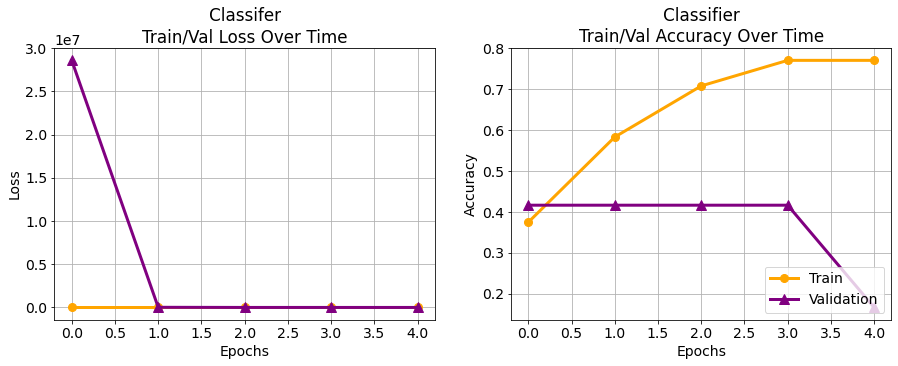

In [7]:
import train
from models import BaselineResnetClassifier

model = BaselineResnetClassifier(num_classes=3)
train.train_voxforge_classifier(model, data_dir=unzip_path)